## Tutorial04 Machine Learning, pattern recognition/classification Part II
* Here, instead of fitting a data set and then deciding which 'cloud' of training data is closer to each test vector, we'll just focus on drawing a boundary that maximizes the margin, or separation, between points that are close together in the two data sets.
* This is the approach implemented by Support Vector Machines (SVMs)

[inspiration for this tutorial...excellent demo of SVMs](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

## Import modules...add some sklean functionality for the SVMs

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.svm import SVC # "Support vector classifier"

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

In [13]:
# num_data_pnts = number of experimental trials
# mu0, mu1 = 2 element np.array that sets the mean of each variable in each condition
# cov0, cov1 = symetric 2 x 2 matrix with main diag specifying the variance of each variable 
# in each condition, and the off diag elements specifying the covariance

def gen_cor_data(num_data_pnts, mu0, mu1, cov0, cov1, plot):

    # number of variables, in this case lets keep it at 2 because that makes it easy to 
    # visualize
    V = 2

    # means of each variable in each condition
    mean_of_data0 = mu0; 
    mean_of_data1 = mu1 

    # generate some random data vectors drawn from normal
    data0 = np.random.randn(num_data_pnts,V) 
    data1 = np.random.randn(num_data_pnts,V) 

    # compute the eigenvalues and eigenvectors of the cov matrix
    evals0, evecs0 = eigh(cov0)
    evals1, evecs1 = eigh(cov1)

    # Construct c, so c*c^T = cov.
    c0 = np.dot(evecs0, np.diag(np.sqrt(evals0)))
    c1 = np.dot(evecs1, np.diag(np.sqrt(evals1)))

    # convert the data using by multiplying data by c
    # to be consistent with previous tutorials, we want the data running down columns...so do the double .T
    cdata0 = np.dot(c0, data0.T).T

    # then add in the mu offset...use np.ones * each condition mean
    cdata0 += np.hstack((np.ones((num_data_pnts,1))*mean_of_data0[0], np.ones((num_data_pnts,1))*mean_of_data0[1]))

    # repeat for the data from the second experimental condition 
    cdata1 = np.dot(c1, data1.T).T
    cdata1 += np.hstack((np.ones((num_data_pnts,1))*mean_of_data1[0], np.ones((num_data_pnts,1))*mean_of_data1[1])) 

    if plot:
        # plot the data...
        plt.scatter(cdata0[:,0], cdata0[:,1], color='b')
        plt.scatter(cdata1[:,0], cdata1[:,1], color='r')
        plt.xlabel('Resp Neuron 1', **fig_font)
        plt.ylabel('Resp Neuron 2', **fig_font)
        plt.legend(['Condition 1', 'Condition 2'])
        plt.show()
    
    return cdata0, cdata1

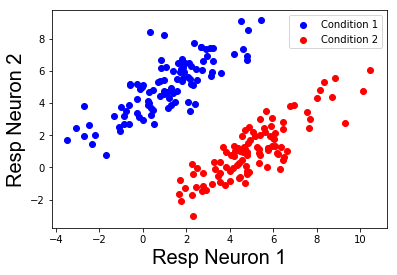

In [28]:
# generate data using our trusty function

np.random.seed(2)

# number of trials
N = 100

# means
mu0 = np.array([1,5])
mu1 = np.array([5,1])

# variance of each neuron
var_of_neuron0 = 3
var_of_neuron1 = 3

# covariance of neurons in each experimental condition 
cov_cond_0 = 2.5
cov_cond_1 = 2.5

cov0 = np.array([
        [var_of_neuron0, cov_cond_0],
        [cov_cond_0, var_of_neuron1]
    ])

cov1 = np.array([
        [var_of_neuron0, cov_cond_1],
        [cov_cond_1, var_of_neuron1]
    ])

# generate the data and plot...
d0, d1 = gen_cor_data(num_data_pnts=N, mu0=mu0, mu1=mu1, cov0=cov0, cov1=cov1, plot=1)

## Now think about drawing a decision boundary that will maximally separate these two classes (i.e. a boundary that will separate data from these two experimental conditions)
* In the case of 2D data like this, then we're looking to just draw a line that separates the two classes
* In higher dim data sets, then we're trying to find the plane (3D) or hyperplane (ND). 
* However, the logic is the same in all cases
* **Important**: Note that there are many lines that can perfectly separate these two classes!
* Given this, how do we select the optimal boundary? 

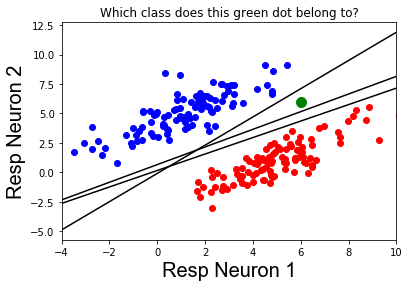

In [51]:
# define some lines that separate these two classes

# start with an x-axis that covers our space
x_range = -4,10
x_vals = np.linspace(x_range[0], x_range[1])

# plot data - note the abbreviated 'color' call
plt.scatter(d0[:, 0], d0[:, 1], c='b')
plt.scatter(d1[:, 0], d1[:, 1], c='r')
plt.xlabel('Resp Neuron 1', **fig_font)
plt.ylabel('Resp Neuron 2', **fig_font)

# draw some lines...y = ax+b...
for a, b in [(.75, 0.65), (.7, 0.15), (1.2, -.1)]:
    plt.plot(x_vals, a * x_vals + b, '-k')

plt.xlim(x_range[0], x_range[1])

# add an extra data point to make a point about 
plt.title('Which class does this green dot belong to?')
plt.plot(6, 6, 'o', c='g', markersize=10)
plt.show()

## Given the ambiguity here about where to draw the boundary, SVMs will instead create a line (or plane or hyperplane) with a margin that extends up to the nearest points in each data set.

(-4, 10)

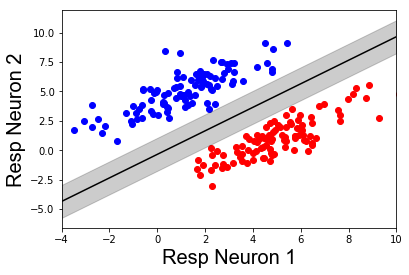

In [99]:
# an x-axis that covers our space
x_range = -4,10
x_vals = np.linspace(x_range[0], x_range[1])

# plot data - note the abbreviated 'color' call
plt.scatter(d0[:, 0], d0[:, 1], c='b')
plt.scatter(d1[:, 0], d1[:, 1], c='r')
plt.xlabel('Resp Neuron 1', **fig_font)
plt.ylabel('Resp Neuron 2', **fig_font)

# plot a sample line + margin that maximizes distance between boundary points.
for a, b, c in [(1, -.35,1.4)]:
    y_vals = a * x_vals + b
    plt.plot(x_vals, y_vals, '-k')
    plt.fill_between(x_vals, y_vals + c, y_vals - c,
                     color='k', alpha=0.2)

plt.xlim(x_range[0], x_range[1])

## So above was just a hand-drawn version of what an SVM is trying to accomplish. Now lets actually implement to see how it works

In [104]:
# we've imported the SVC (support vector classifier) via the sklearn module
# so lets train the classifer using our data...

# first specify the model...linear SVM with a large criterion value (will explain later)
model = SVC(kernel='linear', C=1E10)

# first lets assign parts of our data to train and test sets
percent_train_set = .9
r,c = d0.shape  # get the shape of our data sets
trn_length = int(np.round(percent_train_set*r, 0))

# now assign the first 90% of the trials to the training set...
# we'll stack up the first 90% from the first condition on top 
# of the 90% of data from the second condition
trn_data = np.vstack((d0[0:trn_length,:], d1[0:trn_length,:]))

# and the last 10% of the trials to the test set...
tst_data = np.vstack((d0[trn_length:,:], d1[trn_length:,:]))

# last its helpful to generate a vector that labels the data from each trial
# as belonging to condition 1 or condition 2
trn_labels = np.hstack((np.zeros(trn_length), np.ones(trn_length))).T
tst_labels = np.hstack((np.zeros(r-trn_length), np.ones(r-trn_length))).T

# then fit the model to some data by passing in the data matrix + a list of labels that denotes the 
# experimental condition for each trial
model.fit(trn_data, trn_labels)


SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [ ]:
model.support_vectors_

In [ ]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In [ ]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

In [ ]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

In [ ]:
r = np.exp(-(X ** 2).sum(1))


In [ ]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

In [ ]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');